# **Importation des bibliothéque nécessaires**

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings
from google.colab import files
from bs4 import BeautifulSoup
import requests
import csv


warnings.filterwarnings('ignore')

# **Scrapping**

Pour réaliser ce projet j'ai scrappé environ 150000 Athléthes

In [ ]:
import csv
import requests
from bs4 import BeautifulSoup

# Define the base URL
base_url = 'https://www.olympedia.org'

# Open a CSV file to store the data
with open('olympic.csv', 'w', encoding='utf-8', newline='') as file:
    writer = csv.writer(file)
    # Write header row
    writer.writerow(['Name', 'Sex', 'Nationality', 'Born', 'Height', 'Weight',
                     'Games', 'Year', 'Event', 'Medal'])

    athlete_id = 149800
    athlete_url = f'{base_url}/athletes/{athlete_id}'
    response = requests.get(athlete_url)
    if response.status_code != 200:
        print(f"Failed to retrieve data for athlete ID {athlete_id}")
    else:
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract the athlete's name
        name_element = soup.select_one('h1')
        name = name_element.get_text().strip() if name_element else 'N/A'

        # Extract athlete bio data
        key_items = soup.select('table.biodata > tr > th')
        value_items = soup.select('table.biodata > tr > td')
        athlete_bio_info = {
            key.get_text().strip(): value.get_text().strip()
            for key, value in zip(key_items, value_items)
        }

        # Parse bio information
        sex = athlete_bio_info.get('Sex', 'N/A')
        born = athlete_bio_info.get('Born', 'N/A')
        measurements = athlete_bio_info.get('Measurements', 'N/A')
        height, weight = 'Unknown', 'Unknown'
        nationality = athlete_bio_info.get('NOC', 'N/A')

        if measurements != 'N/A':
            parts = measurements.split(' / ')
            if len(parts) > 1:
                height = parts[0][:-3]  # Remove "cm" or "kg"
                weight = parts[1][:-3]
            elif 'cm' in parts[0]:
                height = parts[0][:-3]
            elif 'kg' in parts[0]:
                weight = parts[0][:-3]

        # Extract competition results
        results_table = soup.select('table.table > tbody > tr')
        for row in results_table:
            columns = row.find_all('td')
            if len(columns) < 5:
                continue
            # Extract data from the results row
            games = columns[0].get_text().strip()
            games_parts = games.split(' ', 1)  # Try splitting into year and season
            year = games_parts[0] if len(games_parts) > 0 else 'N/A'
            season = games_parts[1] if len(games_parts) > 1 else 'N/A'
            event = columns[1].get_text().strip()
            medal = columns[4].get_text().strip() if columns[4].get_text().strip() else 'Nothing'
            # Write the data to the CSV
            writer.writerow([name, sex, nationality, born, height, weight, games, year, event, medal])

print('Scraping completed for athlete ID 1.')


# **Importations du dataset**

In [ ]:
uploaded = files.upload()

Saving olympic.csv to olympic.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['olympic.csv']), encoding='ISO-8859-1', on_bad_lines='skip')


# **Comprehension du dataset**


In [ ]:
df.head()

,Name,Sex,Nationality,Born,Height,Weight,Games,Year,Event,Medal
0,Jean-FranÃ§ois Blanchy,Male,France,"12 December 1886 in Bordeaux, Gironde (FRA)",Unkown,Unkown,1912 Summer Olympics,1912.0,Tennis,Nothing
1,Jean-FranÃ§ois Blanchy,Male,France,"12 December 1886 in Bordeaux, Gironde (FRA)",Unkown,Unkown,NaN,NaN,"Singles, Men\n(Olympic)",Nothing
2,Jean-FranÃ§ois Blanchy,Male,France,"12 December 1886 in Bordeaux, Gironde (FRA)",Unkown,Unkown,NaN,NaN,"Doubles, Men\n(Olympic)",Nothing
3,Jean-FranÃ§ois Blanchy,Male,France,"12 December 1886 in Bordeaux, Gironde (FRA)",Unkown,Unkown,1920 Summer Olympics,1920.0,Tennis,Nothing
4,Jean-FranÃ§ois Blanchy,Male,France,"12 December 1886 in Bordeaux, Gironde (FRA)",Unkown,Unkown,NaN,NaN,"Singles, Men\n(Olympic)",Nothing


In [ ]:
df.shape

(516632, 10)

In [ ]:
df.describe()

,Name,Sex,Nationality,Born,Height,Weight,Games,Year,Event,Medal
count,516632,516632,516632,512291,516632,516632,207038,207038.0,516632,516632
unique,142839,2,696,135531,96,629,62,74.0,1235,4
top,Heikki Savolainen,Male,United States,1931,Unkown,Unkown,2016 Summer Olympics,2020.0,Athletics,Nothing
freq,44,368614,35247,88,116272,124795,11250,12792.0,33220,472233


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516632 entries, 0 to 516631
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Name         516632 non-null  object
 1   Sex          516632 non-null  object
 2   Nationality  516632 non-null  object
 3   Born         512291 non-null  object
 4   Height       516632 non-null  object
 5   Weight       516632 non-null  object
 6   Games        207038 non-null  object
 7   Year         207038 non-null  object
 8   Event        516632 non-null  object
 9   Medal        516632 non-null  object
dtypes: object(10)
memory usage: 39.4+ MB


# **Netoyage aprés Scrapping**

J'ai remplir les colonnes NaN de Games par la valeur de la colonne de la ligne précédente

In [ ]:
df['Games'].fillna(method='ffill', inplace=True)


J'ai ajouté une colonne sport pour que j'aurai une colonne sport et une colonne épreuve

In [ ]:
df['Sport'] = None
last_name = None
first_event = None
for index, row in df.iterrows():
    if row['Name'] != last_name:  # Si un nouveau joueur est trouvé
        first_event = row['Event']  # Prendre la première valeur de 'Event'
    df.at[index, 'Sport'] = first_event  # Assigner cette valeur à 'Sport'
    last_name = row['Name']  # Mettre à jour le dernier nom rencontré
df = df[df['Event'] != df['Sport']]

extraire l'année des jeux olympiques

In [ ]:
df['Annee'] = df['Games'].str.extract(r'(\d{4})')

extraire la date de naissance de l'athléthe

In [ ]:
df['Date de naissance'] = df['Born'].str.extract(r'(\d{4})')


transformer année en entier

In [ ]:
df['Annee'] = df['Annee'].astype(int)


supprimer les colonnes vide de la date de naissance

In [ ]:
df = df.dropna(subset=['Date de naissance'])

tranformer date de naissance en entier

In [ ]:
df['Date de naissance'] = df['Date de naissance'].astype(int)


J'ai ajouté une nouvelle colonne pour calculer l'age pour chaque athléthe particiapnt pandant le jeux olympique

In [ ]:
# Calculer l'âge
df['Age'] = df['Annee'] - df['Date de naissance']




J'ai supprimé les colonnes inutiles

In [ ]:
df = df.drop(columns=['Born', 'Games', 'Year'])


In [ ]:
df.head()

,Name,Sex,Nationality,Height,Weight,Event,Medal,Sport,Annee,Date de naissance,Age
1,Jean-FranÃ§ois Blanchy,Male,France,Unkown,Unkown,"Singles, Men\n(Olympic)",Nothing,Tennis,1912,1886,26
2,Jean-FranÃ§ois Blanchy,Male,France,Unkown,Unkown,"Doubles, Men\n(Olympic)",Nothing,Tennis,1912,1886,26
4,Jean-FranÃ§ois Blanchy,Male,France,Unkown,Unkown,"Singles, Men\n(Olympic)",Nothing,Tennis,1920,1886,34
5,Jean-FranÃ§ois Blanchy,Male,France,Unkown,Unkown,"Doubles, Mixed\n(Olympic)",Nothing,Tennis,1920,1886,34
6,Jean-FranÃ§ois Blanchy,Male,France,Unkown,Unkown,"Doubles, Men\n(Olympic)",Nothing,Tennis,1920,1886,34


j'ai filtré suelement les jeux olympiques d'été car il ya jo en hiver aussi

In [ ]:
# Liste des années que vous souhaitez conserver
olympic_years = [1896, 1900, 1904, 1908, 1912, 1916, 1920, 1924, 1928, 1932, 1936, 1940, 1944,
                 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992,
                 1996, 2000, 2004, 2008, 2012, 2016, 2020]

# Filtrer le DataFrame pour ne garder que ces années
df = df[df['Annee'].isin(olympic_years)]



suppression de duplicate lignes

In [ ]:
df=df.drop_duplicates()
df.shape

(307791, 11)

In [ ]:
df = df.dropna()
df.shape

(307791, 11)

une petite visualisation

In [ ]:
df.isnull().sum()

,0
Name,0
Sex,0
Nationality,0
Height,0
Weight,0
Event,0
Medal,0
Sport,0
Annee,0
Date de naissance,0


Finalement aprés scrapping on a ce résultat

In [ ]:
df.shape

(307791, 11)

In [ ]:
df.head()

,Name,Sex,Nationality,Height,Weight,Event,Medal,Sport,Annee,Date de naissance,Age
1,Jean-FranÃ§ois Blanchy,Male,France,Unkown,Unkown,"Singles, Men\n(Olympic)",Nothing,Tennis,1912,1886,26
2,Jean-FranÃ§ois Blanchy,Male,France,Unkown,Unkown,"Doubles, Men\n(Olympic)",Nothing,Tennis,1912,1886,26
4,Jean-FranÃ§ois Blanchy,Male,France,Unkown,Unkown,"Singles, Men\n(Olympic)",Nothing,Tennis,1920,1886,34
5,Jean-FranÃ§ois Blanchy,Male,France,Unkown,Unkown,"Doubles, Mixed\n(Olympic)",Nothing,Tennis,1920,1886,34
6,Jean-FranÃ§ois Blanchy,Male,France,Unkown,Unkown,"Doubles, Men\n(Olympic)",Nothing,Tennis,1920,1886,34


In [ ]:
df.to_csv('olympicnew.csv', index=False)

# **Comparaison avant et aprés nettoyage**

In [ ]:
df.head()

,Name,Sex,Nationality,Born,Height,Weight,Games,Year,Event,Medal
0,Jean-FranÃ§ois Blanchy,Male,France,"12 December 1886 in Bordeaux, Gironde (FRA)",Unkown,Unkown,1912 Summer Olympics,1912.0,Tennis,Nothing
1,Jean-FranÃ§ois Blanchy,Male,France,"12 December 1886 in Bordeaux, Gironde (FRA)",Unkown,Unkown,NaN,NaN,"Singles, Men\n(Olympic)",Nothing
2,Jean-FranÃ§ois Blanchy,Male,France,"12 December 1886 in Bordeaux, Gironde (FRA)",Unkown,Unkown,NaN,NaN,"Doubles, Men\n(Olympic)",Nothing
3,Jean-FranÃ§ois Blanchy,Male,France,"12 December 1886 in Bordeaux, Gironde (FRA)",Unkown,Unkown,1920 Summer Olympics,1920.0,Tennis,Nothing
4,Jean-FranÃ§ois Blanchy,Male,France,"12 December 1886 in Bordeaux, Gironde (FRA)",Unkown,Unkown,NaN,NaN,"Singles, Men\n(Olympic)",Nothing


In [ ]:
df.shape

(516632, 10)

In [ ]:
df.head()

,Name,Sex,Nationality,Height,Weight,Event,Medal,Sport,Annee,Date de naissance,Age
1,Jean-FranÃ§ois Blanchy,Male,France,Unkown,Unkown,"Singles, Men\n(Olympic)",Nothing,Tennis,1912,1886,26
2,Jean-FranÃ§ois Blanchy,Male,France,Unkown,Unkown,"Doubles, Men\n(Olympic)",Nothing,Tennis,1912,1886,26
4,Jean-FranÃ§ois Blanchy,Male,France,Unkown,Unkown,"Singles, Men\n(Olympic)",Nothing,Tennis,1920,1886,34
5,Jean-FranÃ§ois Blanchy,Male,France,Unkown,Unkown,"Doubles, Mixed\n(Olympic)",Nothing,Tennis,1920,1886,34
6,Jean-FranÃ§ois Blanchy,Male,France,Unkown,Unkown,"Doubles, Men\n(Olympic)",Nothing,Tennis,1920,1886,34


In [ ]:
df.shape

(307791, 11)

**Conclusion**

***Avant :***
*   516632 lignes et 10 colonnes

---


***Aprés :***

*   307791 lignes et 11 colonnes



# **Analyse Edition**

In [ ]:
# Créer un histogramme pour la colonne 'Sex'
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df['Sex'],
    marker_color='blue',
    opacity=0.75
))

# Mettre à jour le layout pour l'histogramme
fig.update_layout(
    title_text='Répartition des sexes des athlètes',
    xaxis_title_text='Sexe',
    yaxis_title_text='Nombre d\'athlètes',
    bargap=0.2,
    bargroupgap=0.1
)

# Afficher le graphique
fig.show()


Conclusion : 2/3 athléthe homme et 1/3 femme presque:

In [ ]:
# Compter le nombre de participations uniques par année
participations_by_year = df.groupby('Annee')['Name'].nunique().reset_index(name='Number of Unique Participations')

# Afficher le nombre de participations uniques par année
print(participations_by_year)


    Annee  Number of Unique Participations
0    1896                              127
1    1900                              881
2    1904                              591
3    1908                             1975
4    1912                             2419
5    1920                             2491
6    1924                             3466
7    1928                             3263
8    1932                             1613
9    1936                             4658
10   1948                             4648
11   1952                             5676
12   1956                             4204
13   1960                             6084
14   1964                             6269
15   1968                             6763
16   1972                             8168
17   1976                             7306
18   1980                             6263
19   1984                             8069
20   1988                            10031
21   1992                            11257
22   1996  

conclusion : entre en 60 ans entre 1960 et 2020 le nombre d'athléthe est multiplié

<Axes: title={'center': 'Évolution des participations par année'}, xlabel='Annee'>

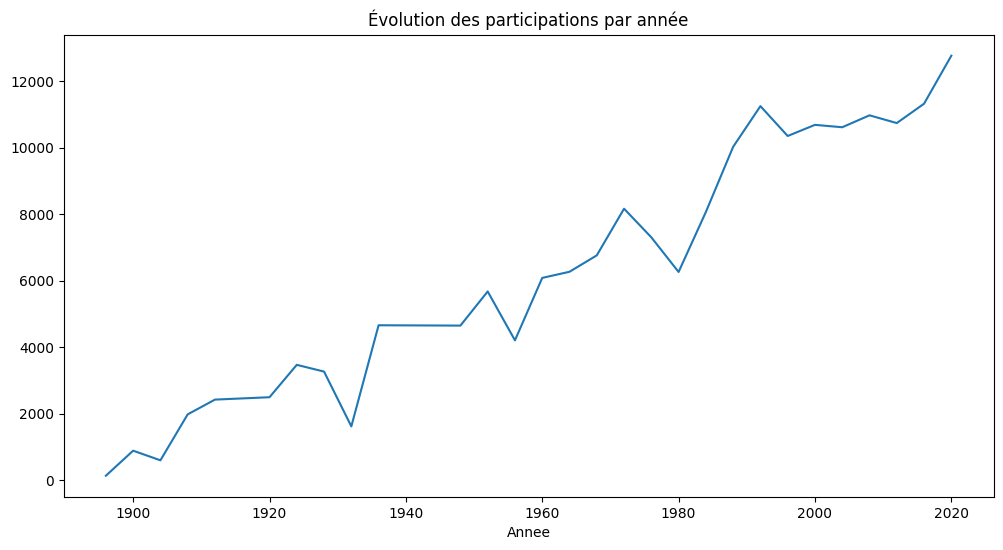

In [ ]:
athletes_by_year = df.groupby('Annee')['Name'].nunique()
athletes_by_year.plot(kind='line', figsize=(12, 6), title='Évolution des participations par année')


Conclusion : Malgré le covide et l'Épidémie en 2020 il ya un record des athléthes participants

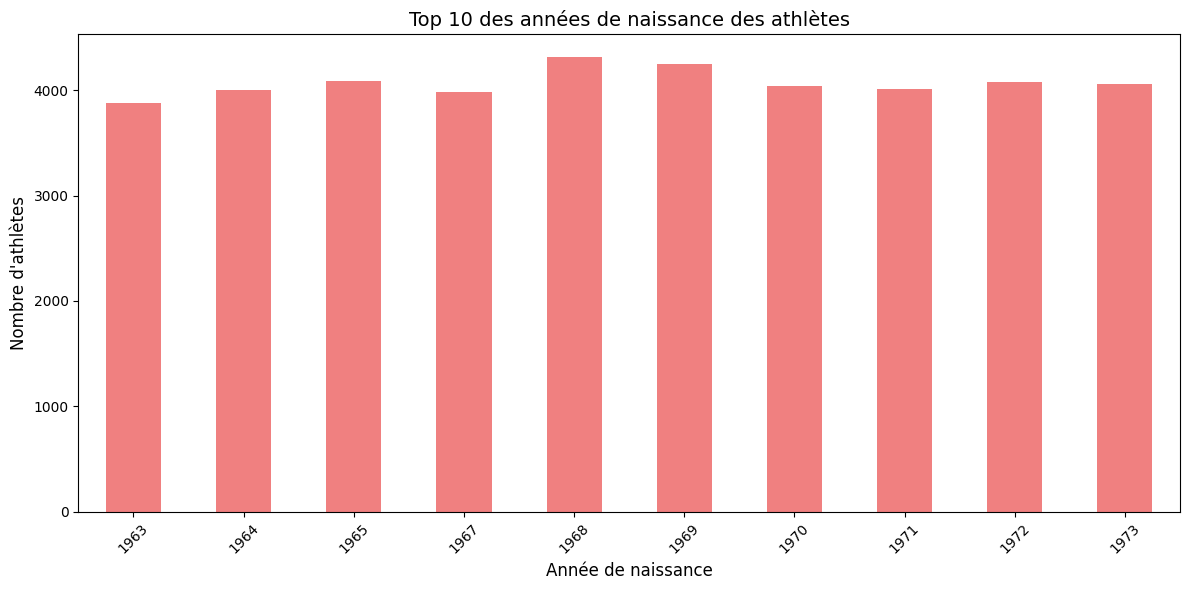

In [ ]:
# Répartition des athlètes par année de naissance (top 10)
athletes_by_birth_year_top10 = df['Date de naissance'].value_counts().nlargest(10).sort_index()

# Afficher sous forme de graphique
plt.figure(figsize=(12, 6))
athletes_by_birth_year_top10.plot(kind='bar', color='lightcoral')
plt.title("Top 10 des années de naissance des athlètes", fontsize=14)
plt.xlabel("Année de naissance", fontsize=12)
plt.ylabel("Nombre d'athlètes", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


conclusion : entre les années 1963 et 1973 il y a plus de naissance des athléthes

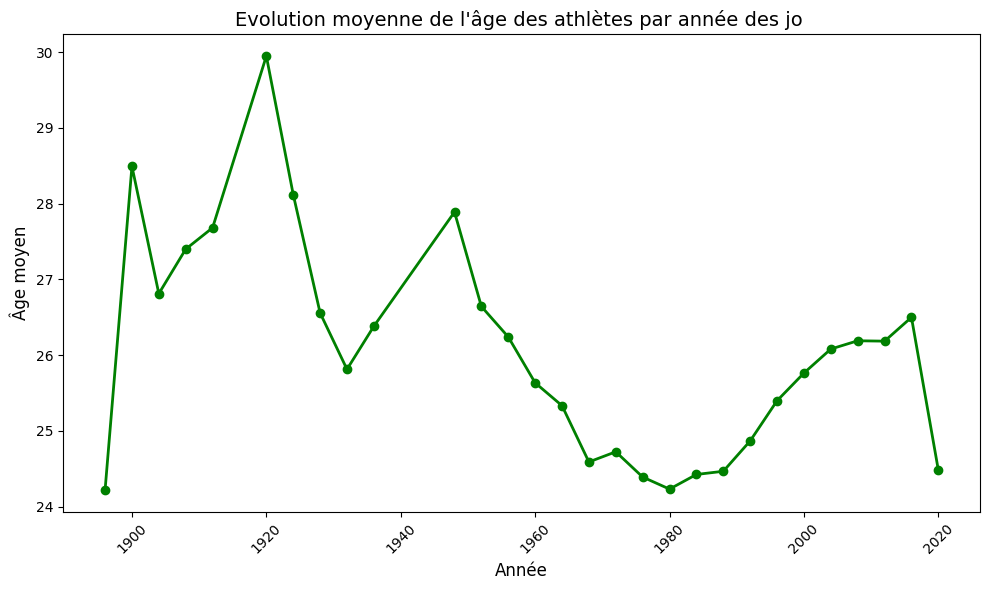

In [ ]:
age_by_year = df.groupby('Annee')['Age'].mean()

# Afficher le graphique
plt.figure(figsize=(10, 6))
age_by_year.plot(kind='line', marker='o', color='green', linestyle='-', linewidth=2)
plt.title("Evolution moyenne de l'âge des athlètes par année des jo ", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Âge moyen", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


description : 2016 presque 27 ans moyenne d'age et en 2020 presque 23 ans donc il ya une diminution

# **Analyse par Sport**

In [ ]:
# Afficher les sports uniques dans la colonne 'Sport' du DataFrame
sports_list = df['Sport'].unique()

# Afficher la liste des sports
print(sports_list)


['Tennis' 'Table Tennis' 'Fencing' 'Badminton' 'Hockey' 'Athletics'
 'Modern Pentathlon' 'Archery' 'Boxing' 'Softball (Baseball/Softball)'
 'Baseball (Baseball/Softball)' 'Sailing' 'Golf' 'Basketball (Basketball)'
 'Cycling Road (Cycling)' 'Australian Rules Football'
 'Canoe Sprint (Canoeing)' 'Canoe Slalom (Canoeing)'
 'Canoe Marathon (Canoeing)' 'Cycling Track (Cycling)' 'Polo'
 'Rugby (Rugby)' 'Equestrian Dressage (Equestrian)'
 'Equestrian Eventing (Equestrian)' 'Equestrian Jumping (Equestrian)'
 'Tug-Of-War' 'Lacrosse' 'Diving (Aquatics)' 'Winter Pentathlon'
 'Equestrian Vaulting (Equestrian)' 'Equestrian Driving (Equestrian)'
 'Cycling Mountain Bike (Cycling)' 'Rowing' 'Bicycle Polo (Cycling)'
 'Racquets' 'Bobsleigh (Bobsleigh)' 'Cricket' 'Croquet' 'Motorboating'
 'Jeu De Paume' 'Swimming (Aquatics)' 'Ice Hockey (Ice Hockey)'
 'Art Competitions' 'Football (Football)'
 'Artistic Gymnastics (Gymnastics)' 'Rhythmic Gymnastics (Gymnastics)'
 'Wrestling' 'Handball' 'Judo' 'Shooting' '

Conlusion : il ya une varité de sport dans les jeux olympiques

In [ ]:
# Filtrer les événements contenant le mot "Mixed"
mixed_events = df[df['Event'].str.contains('Mixed', case=False, na=False)]

# Afficher les événements et les sports associés
print("Les sports qui ont mixé par équipes' :")
print(mixed_events[['Sport']].drop_duplicates())


Les sports qui ont mixé par équipes' :
                                      Sport
5                                    Tennis
51                                  Fencing
221                               Badminton
7056                                Archery
9194                                Sailing
9930                                   Golf
257303                            Athletics
279048             Figure Skating (Skating)
316204              Speed Skating (Skating)
328838                             Shooting
358266                              Curling
369786                  Swimming (Aquatics)
380027                            Triathlon
385455                         Table Tennis
404411                                 Judo
454386                                 Luge
455057                 Ski Jumping (Skiing)
455590             Nordic Combined (Skiing)
456489                             Biathlon
456813  Short Track Speed Skating (Skating)
458948                         Mixed 

conclusion : il ya des sport mix qu'on peut trouve dans le méme équipe des hommes et des femmes

In [ ]:
# Grouper par sport et sex, puis compter le nombre unique de sexes par sport
sports_gender = df.groupby('Sport')['Sex'].nunique()

# Filtrer les sports qui ont à la fois des hommes et des femmes
sports_both_genders = sports_gender[sports_gender > 1].index

# Afficher les sports joués par les deux sexes
print("Les sports qui peuvent être joués par des hommes et des femmes sont :")
print(sports_both_genders)


Les sports qui peuvent être joués par des hommes et des femmes sont :
Index(['3-on-3 Ice Hockey (Ice Hockey)', '3x3 Basketball (Basketball)',
       'Alpine Skiing (Skiing)', 'Archery', 'Artistic Gymnastics (Gymnastics)',
       'Athletics', 'Badminton', 'Basketball (Basketball)',
       'Beach Volleyball (Volleyball)', 'Biathlon', 'Bobsleigh (Bobsleigh)',
       'Boxing', 'Canoe Slalom (Canoeing)', 'Canoe Sprint (Canoeing)',
       'Croquet', 'Cross Country Skiing (Skiing)', 'Curling',
       'Cycling BMX Freestyle (Cycling)', 'Cycling BMX Racing (Cycling)',
       'Cycling Mountain Bike (Cycling)', 'Cycling Road (Cycling)',
       'Cycling Track (Cycling)', 'Diving (Aquatics)',
       'Equestrian Dressage (Equestrian)', 'Equestrian Eventing (Equestrian)',
       'Equestrian Jumping (Equestrian)', 'Fencing',
       'Figure Skating (Skating)', 'Football (Football)',
       'Freestyle Skiing (Skiing)', 'Golf', 'Handball', 'Hockey', 'Hockey 5s',
       'Ice Hockey (Ice Hockey)', 'Judo', 

Conclusion : il ya des sport en commun pour les femmes et les hommes

In [ ]:
# Filtrer les événements contenant "Doubles" et "Men"
events_doubles_men = df[df['Event'].str.contains('Doubles', case=False) & df['Event'].str.contains('Men', case=False)]

# Obtenir les événements uniques
unique_events = events_doubles_men['Event'].unique()
# Obtenir les sports uniques
unique_sports = events_doubles_men['Sport'].unique()

# Afficher les sports uniques
print("Les sports qui ont joué en jeux olympiques par double ")
print(unique_sports)


Les sports qui ont joué en jeux olympiques par double 
['Tennis' 'Table Tennis' 'Fencing' 'Badminton' 'Hockey' 'Athletics'
 'Sailing' 'Golf' 'Canoe Sprint (Canoeing)' 'Canoe Slalom (Canoeing)'
 'Canoe Marathon (Canoeing)' 'Racquets' 'Jeu De Paume'
 'Swimming (Aquatics)']


In [ ]:
# Filtrer les événements contenant "Doubles" et "Men"
events_doubles_men = df[df['Event'].str.contains('Doubles, Women', case=False) & df['Event'].str.contains('Men', case=False)]

# Obtenir les événements uniques
unique_events = events_doubles_men['Event'].unique()
# Obtenir les sports uniques
unique_sports = events_doubles_men['Sport'].unique()

# Afficher les sports uniques
print("Les sports qui ont joué en jeux olympiques par double Femme")
print(unique_sports)

Les sports qui ont joué en jeux olympiques par double Femme
['Tennis' 'Badminton' 'Table Tennis']


In [ ]:
# Filtrer les événements contenant "Doubles" et "Men"
events_doubles_men = df[df['Event'].str.contains('Doubles, Men', case=False) & df['Event'].str.contains('Men', case=False)]

# Obtenir les événements uniques
unique_events = events_doubles_men['Event'].unique()
# Obtenir les sports uniques
unique_sports = events_doubles_men['Sport'].unique()

# Afficher les sports uniques
print("Les sports qui ont joué en jeux olympiques par double Homme")
print(unique_sports)

Les sports qui ont joué en jeux olympiques par double Homme
['Tennis' 'Table Tennis' 'Fencing' 'Badminton' 'Hockey' 'Athletics'
 'Sailing' 'Golf' 'Racquets' 'Jeu De Paume']


Conclusion ; il ya plus de sport double pour les hommes que pour les femmes

In [ ]:
# Filtrer les sports pour l'année 1896
sports_1896 = df[df['Annee'] == 1896]['Sport'].unique()

# Filtrer les sports pour l'année 2020
sports_2020 = df[df['Annee'] == 2020]['Sport'].unique()

# Trouver l'intersection des sports entre 1896 et 2020
common_sports = set(sports_1896).intersection(set(sports_2020))

# Afficher les sports communs
print(f"Les sports joués à la fois en 1896 et en 2020 sont :\n" + "\n".join(common_sports))


Les sports joués à la fois en 1896 et en 2020 sont :
Cycling Road (Cycling)
Shooting
Tennis
Artistic Gymnastics (Gymnastics)
Wrestling
Fencing
Athletics
Swimming (Aquatics)
Weightlifting


conclusion : il y a des sports présent en 1896 et 2020

In [ ]:
# Obtenir la liste unique des années où des compétitions ont eu lieu
competition_years = df['Annee'].unique()

# Filtrer les sports présents dans toutes les compétitions
all_sports = df.groupby('Sport')['Annee'].nunique()

# Filtrer les sports qui sont présents dans toutes les années
sports_in_all_years = all_sports[all_sports == len(competition_years)].index

# Afficher les sports présents dans toutes les compétitions
print(f"Les sports présents dans toutes les compétitions sont : {', '.join(sports_in_all_years)}")


Les sports présents dans toutes les compétitions sont : Artistic Gymnastics (Gymnastics), Athletics, Fencing, Swimming (Aquatics)


conclusion : il y a des sports présent depuis 1896 pour tout les éditions

# **Analyse par Joueur**

In [ ]:
# Compter le nombre de médailles par joueur (exclure "Nothing")
medal_counts = df[df['Medal'] != 'Nothing'].groupby('Name')['Medal'].count()

# Identifier le joueur avec le plus grand nombre de médailles
most_medals_player = medal_counts.idxmax()
most_medals_count = medal_counts.max()

# Afficher le joueur avec le plus grand nombre de médailles
print(f"Le joueur le plus médaillé est {most_medals_player} avec {most_medals_count} médailles.")

# Filtrer les données pour afficher uniquement les lignes avec une médaille réelle (exclure "Nothing")
most_medals_player_data = df[(df['Name'] == most_medals_player) & (df['Medal'] != 'Nothing')][['Annee','Medal','Event']]

# Afficher les résultats
print(most_medals_player_data)

# Calculer le nombre total de participations (Gold + Silver + Bronze)
participation_count = df[df['Name'] == most_medals_player][df['Medal'].isin(['Gold', 'Silver', 'Bronze','Nothing'])].shape[0]

# Afficher le nombre de participations
print(f"Le joueur {most_medals_player} a participé à {participation_count} épreuves ")

Le joueur le plus médaillé est Michael Phelps avec 28 médailles.
        Annee   Medal                                            Event
332235   2004  Bronze             200 metres Freestyle, Men\n(Olympic)
332236   2004  Bronze  4 Ã 100 metres Freestyle Relay, Men\n(Olympic)
332237   2004    Gold  4 Ã 200 metres Freestyle Relay, Men\n(Olympic)
332238   2004    Gold             100 metres Butterfly, Men\n(Olympic)
332239   2004    Gold             200 metres Butterfly, Men\n(Olympic)
332240   2004    Gold     200 metres Individual Medley, Men\n(Olympic)
332241   2004    Gold     400 metres Individual Medley, Men\n(Olympic)
332242   2004    Gold     4 Ã 100 metres Medley Relay, Men\n(Olympic)
332244   2008    Gold             200 metres Freestyle, Men\n(Olympic)
332245   2008    Gold  4 Ã 100 metres Freestyle Relay, Men\n(Olympic)
332246   2008    Gold  4 Ã 200 metres Freestyle Relay, Men\n(Olympic)
332247   2008    Gold             100 metres Butterfly, Men\n(Olympic)
332248   200

In [ ]:
# Filtrer les médailles de Bronze uniquement
bronze_medal_counts = df[df['Medal'] == 'Bronze'].groupby('Name')['Medal'].count()

# Identifier le joueur avec le plus grand nombre de médailles de Bronze
most_bronze_medals_player = bronze_medal_counts.idxmax()
most_bronze_medals_count = bronze_medal_counts.max()

# Afficher le joueur avec le plus grand nombre de médailles de Bronze
print(f"Le joueur le plus médaillé en Bronze est {most_bronze_medals_player} avec {most_bronze_medals_count} médailles.")

# Filtrer les données pour afficher uniquement les lignes avec des médailles de Bronze pour ce joueur
most_bronze_medals_player_data = df[(df['Name'] == most_bronze_medals_player) & (df['Medal'] == 'Bronze')][['Annee', 'Medal', 'Event']]

# Afficher les résultats
print(most_bronze_medals_player_data)


Le joueur le plus médaillé en Bronze est Aleksey Nemov avec 6 médailles.
        Annee   Medal                            Event
110375   1996  Bronze   Floor Exercise, Men\n(Olympic)
110378   1996  Bronze   Horizontal Bar, Men\n(Olympic)
110380   1996  Bronze  Pommelled Horse, Men\n(Olympic)
110383   2000  Bronze  Team All-Around, Men\n(Olympic)
110386   2000  Bronze    Parallel Bars, Men\n(Olympic)
110389   2000  Bronze  Pommelled Horse, Men\n(Olympic)


In [ ]:
# Filtrer les médailles d'argent uniquement
silver_medal_counts = df[df['Medal'] == 'Silver'].groupby('Name')['Medal'].count()

# Identifier le joueur avec le plus grand nombre de médailles d'argent
most_silver_medals_player = silver_medal_counts.idxmax()
most_silver_medals_count = silver_medal_counts.max()

# Afficher le joueur avec le plus grand nombre de médailles d'argent
print(f"Le joueur le plus médaillé en Silver est {most_silver_medals_player} avec {most_silver_medals_count} médailles.")

# Filtrer les données pour afficher uniquement les lignes avec des médailles d'argent pour ce joueur
most_silver_medals_player_data = df[(df['Name'] == most_silver_medals_player) & (df['Medal'] == 'Silver')][['Annee', 'Medal', 'Event']]

# Afficher les résultats
print(most_silver_medals_player_data)


Le joueur le plus médaillé en Silver est Aleksandr Dityatin avec 6 médailles.
        Annee   Medal                            Event
112798   1976  Silver  Team All-Around, Men\n(Olympic)
112803   1976  Silver            Rings, Men\n(Olympic)
112809   1980  Silver      Horse Vault, Men\n(Olympic)
112810   1980  Silver    Parallel Bars, Men\n(Olympic)
112811   1980  Silver   Horizontal Bar, Men\n(Olympic)
112813   1980  Silver  Pommelled Horse, Men\n(Olympic)


In [ ]:
# Filtrer les médailles d'or uniquement
gold_medal_counts = df[df['Medal'] == 'Gold'].groupby('Name')['Medal'].count()

# Identifier le joueur avec le plus grand nombre de médailles d'or
most_gold_medals_player = gold_medal_counts.idxmax()
most_gold_medals_count = gold_medal_counts.max()

# Afficher le joueur avec le plus grand nombre de médailles d'or
print(f"Le joueur le plus médaillé en Gold est {most_gold_medals_player} avec {most_gold_medals_count} médailles.")

# Filtrer les données pour afficher uniquement les lignes avec des médailles d'or pour ce joueur
most_gold_medals_player_data = df[(df['Name'] == most_gold_medals_player) & (df['Medal'] == 'Gold')][['Annee', 'Medal', 'Event']]

# Afficher les résultats
print(most_gold_medals_player_data)


Le joueur le plus médaillé en Gold est Michael Phelps avec 23 médailles.
        Annee Medal                                            Event
332237   2004  Gold  4 Ã 200 metres Freestyle Relay, Men\n(Olympic)
332238   2004  Gold             100 metres Butterfly, Men\n(Olympic)
332239   2004  Gold             200 metres Butterfly, Men\n(Olympic)
332240   2004  Gold     200 metres Individual Medley, Men\n(Olympic)
332241   2004  Gold     400 metres Individual Medley, Men\n(Olympic)
332242   2004  Gold     4 Ã 100 metres Medley Relay, Men\n(Olympic)
332244   2008  Gold             200 metres Freestyle, Men\n(Olympic)
332245   2008  Gold  4 Ã 100 metres Freestyle Relay, Men\n(Olympic)
332246   2008  Gold  4 Ã 200 metres Freestyle Relay, Men\n(Olympic)
332247   2008  Gold             100 metres Butterfly, Men\n(Olympic)
332248   2008  Gold             200 metres Butterfly, Men\n(Olympic)
332249   2008  Gold     200 metres Individual Medley, Men\n(Olympic)
332250   2008  Gold     400 me

In [ ]:
# Compter le nombre de participations de chaque joueur dans chaque sport
player_sport_count = df.groupby(['Name']).size().reset_index(name='count')

# Compter le nombre total de sports différents auxquels chaque joueur a participé
player_total_sports = player_sport_count.groupby('Name')['count'].sum().reset_index()

# Trouver le joueur avec le plus grand nombre de participations
top_player = player_total_sports.loc[player_total_sports['count'].idxmax()]

# Afficher le nom du joueur et le nombre de participations
print(f"Le joueur le plus joué dans des épreuves est {top_player['Name']} avec {top_player['count']} participations.")

# Filtrer les années du joueur ayant le plus participé
player_years = df[df['Name'] == top_player['Name']]['Annee'].unique()

# Afficher les années
print(f"Les années où {top_player['Name']} a participé sont : {', '.join(map(str, sorted(player_years)))}.")

# Compter le nombre de médailles par type pour le joueur ayant le plus de participations
medals_by_player = df[df['Name'] == top_player['Name']]['Medal'].value_counts()

# Afficher le nombre de médailles pour chaque type
print(f"Le joueur {top_player['Name']} a remporté les médailles suivantes :")
for medal, count in medals_by_player.items():
    print(f"{medal}: {count}")

Le joueur le plus joué dans des épreuves est Heikki Savolainen avec 39 participations.
Les années où Heikki Savolainen a participé sont : 1928, 1932, 1936, 1948, 1952.
Le joueur Heikki Savolainen a remporté les médailles suivantes :
Nothing: 30
Bronze: 6
Gold: 2
Silver: 1


In [ ]:
# Compter le nombre de participations par joueur et par année
participations_count = df.groupby(['Name', 'Annee']).size().reset_index(name='Participations')

# Trouver le joueur ayant le maximum de participations
max_participations_player = participations_count.loc[participations_count['Participations'].idxmax()]

# Afficher le joueur avec le plus grand nombre de participations par année
print(f"Le joueur ayant participé le plus de fois par année aux Jeux Olympiques est : {max_participations_player['Name']}, avec {max_participations_player['Participations']} participations en {max_participations_player['Annee']}.")


Le joueur ayant participé le plus de fois par année aux Jeux Olympiques est : Carl Schuhmann, avec 18 participations en 1896.


In [ ]:
# Trouver l'index du joueur le plus jeune
min_age_index = df['Age'].idxmin()

# Obtenir les détails du joueur le plus jeune
youngest_player = df.loc[min_age_index]

# Afficher le message avec le nom, l'âge entier et l'année des Jeux Olympiques
print(f"Le joueur le plus jeune ayant participé aux Jeux Olympiques est : {youngest_player['Name']}, avec un âge de {int(youngest_player['Age'])} ans, et il a participé aux Jeux Olympiques de {youngest_player['Annee']}.")


Le joueur le plus jeune ayant participé aux Jeux Olympiques est : Dimitrios Loundras, avec un âge de 11 ans, et il a participé aux Jeux Olympiques de 1896.


conclusion : Ce jeune athléthe, est le plus jeune participant des Jeux Olympiques de 1896, incarnant l'inspiration pour les jeunes athlètes.








In [ ]:
# Trouver l'index du joueur le plus âgé
max_age_index = df['Age'].idxmax()

# Obtenir les détails du joueur le plus âgé
oldest_player = df.loc[max_age_index]

# Afficher le message avec le nom, l'âge entier et l'année des Jeux Olympiques
print(f"Le joueur le plus âgé ayant participé aux Jeux Olympiques est : {oldest_player['Name']}, avec un âge de {int(oldest_player['Age'])} ans, et il a participé aux Jeux Olympiques de {oldest_player['Annee']}.")


Le joueur le plus âgé ayant participé aux Jeux Olympiques est : Oscar Swahn, avec un âge de 73 ans, et il a participé aux Jeux Olympiques de 1920.


Conclusion : l'age est un qu'un chiffre dans le sport

Top 10 des athlètes avec le plus grand nombre de participations:
Name
Ratko RudiÄ         11
Ian Millar           10
ZÃ© Roberto           9
Antonio GarcÃ­a       9
Sven Johansson        9
Vladimir Andreyev     9
Luis MartÃ­nez        9
Nino Salukvadze       9
JosÃ© Ramos           9
Hubert Raudaschl      9
Name: Annee, dtype: int64


<Axes: title={'center': 'Top 10 des athlètes avec le plus grand nombre de participations'}, xlabel='Name'>

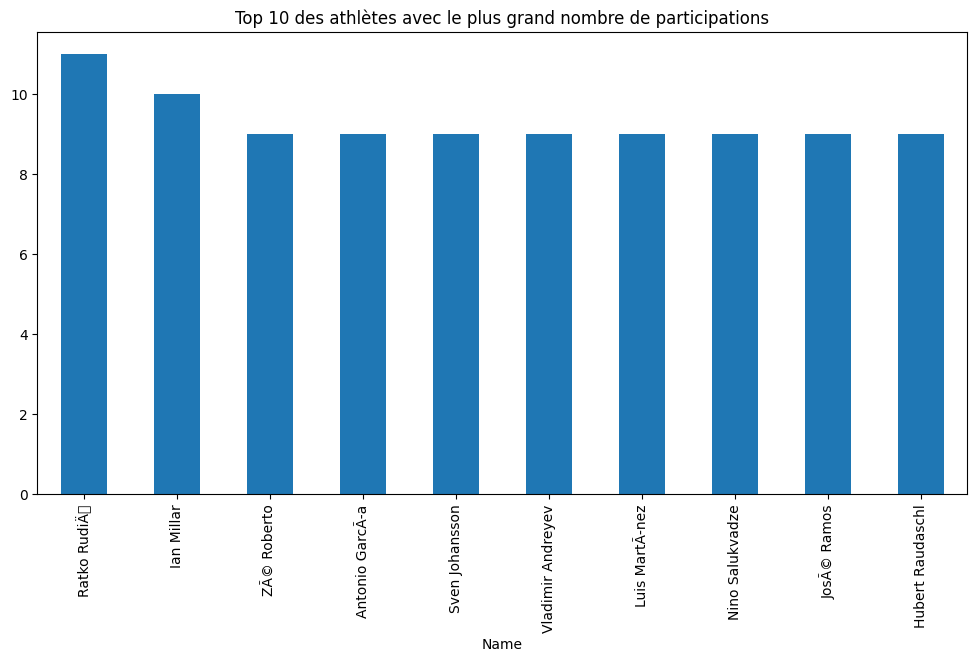

In [ ]:
# Trouver les athlètes avec le plus grand nombre de participations
athlete_participations = df.groupby('Name')['Annee'].nunique().sort_values(ascending=False).head(10)

# Afficher les athlètes du top 10
print("Top 10 des athlètes avec le plus grand nombre de participations:")
print(athlete_participations)

# Visualiser le top 10 des athlètes avec un graphique à barres
athlete_participations.plot(kind='bar', figsize=(12, 6), title='Top 10 des athlètes avec le plus grand nombre de participations')


# **Analyse par Nation**

In [ ]:
import pandas as pd
import plotly.express as px

# Supposons que votre DataFrame s'appelle df et contient des colonnes 'Nationality' et 'Athlete'
# Compter le nombre d'athlètes par pays
athlete_counts_by_country = df['Nationality'].value_counts()

# Trier par ordre décroissant et obtenir les 10 premiers pays
top_10_athletes_countries = athlete_counts_by_country.head(10)

# Créer un DataFrame pour les 10 premiers pays
top_10_athletes_df = top_10_athletes_countries.reset_index()
top_10_athletes_df.columns = ['Pays', 'Nombre d\'athlètes']

# Créer un graphique à barres
fig = px.bar(top_10_athletes_df, x='Pays', y='Nombre d\'athlètes', title='Top 10 pays avec le plus d\'athlètes', labels={'Pays': 'Pays', 'Nombre d\'athlètes': 'Nombre d\'athlètes'})

# Afficher le graphique
fig.show()

Conclusion : USA est plus de nombre d'athléthes dans tout les éditions

In [ ]:
import plotly.express as px

# Compter les médailles (Gold, Silver, Bronze) par pays
medal_counts_by_country = df[df['Medal'].isin(['Gold', 'Silver', 'Bronze'])].groupby(['Nationality', 'Medal']).size().unstack(fill_value=0)

# Trier les pays par nombre total de médailles
medal_counts_by_country['Total'] = medal_counts_by_country.sum(axis=1)
top_10_countries = medal_counts_by_country.sort_values('Total', ascending=False).head(10)

# Créer un graphique à barres empilées
fig = px.bar(top_10_countries, x=top_10_countries.index, y=['Gold', 'Silver', 'Bronze'],
             title='Top 10 pays avec les médailles (Or, Argent, Bronze)',
             labels={'x': 'Pays', 'y': 'Nombre de médailles'},
             color_discrete_map={'Gold': 'gold', 'Silver': 'silver', 'Bronze': '#cd7f32'})

# Afficher le graphique
fig.show()


Conlusion : USA domine dans tout les médailles

In [ ]:
import plotly.express as px

# Compter les médailles d'or par pays
medal_counts_by_country = df[df['Medal'] == 'Gold'].groupby('Nationality').size()

# Trier par ordre décroissant et obtenir les 10 premiers pays
top_10_countries = medal_counts_by_country.sort_values(ascending=False).head(10)

# Créer un DataFrame pour les 10 premiers pays
top_10_countries_df = top_10_countries.reset_index(name='Medal')

# Créer un graphique à barres
fig = px.bar(top_10_countries_df, x='Nationality', y='Medal', title='Top 10 pays médaillés en Or', labels={'Nationality': 'Pays', 'Medal': 'Nombre de médailles d\'or'})

# Afficher le graphique
fig.show()


In [ ]:
import plotly.express as px

# Compter les médailles d'argent par pays
medal_counts_by_country = df[df['Medal'] == 'Silver'].groupby('Nationality').size()

# Trier par ordre décroissant et obtenir les 10 premiers pays
top_10_countries = medal_counts_by_country.sort_values(ascending=False).head(10)

# Créer un DataFrame pour les 10 premiers pays
top_10_countries_df = top_10_countries.reset_index(name='Medal')

# Créer un graphique à barres
fig = px.bar(top_10_countries_df, x='Nationality', y='Medal', title='Top 10 pays médaillés en Argent', labels={'Nationality': 'Pays', 'Medal': 'Nombre de médailles d\'argent'})

# Afficher le graphique
fig.show()


In [ ]:
import plotly.express as px

# Compter les médailles de bronze par pays
medal_counts_by_country = df[df['Medal'] == 'Bronze'].groupby('Nationality').size()

# Trier par ordre décroissant et obtenir les 10 premiers pays
top_10_countries = medal_counts_by_country.sort_values(ascending=False).head(10)

# Créer un DataFrame pour les 10 premiers pays
top_10_countries_df = top_10_countries.reset_index(name='Medal')

# Créer un graphique à barres
fig = px.bar(top_10_countries_df, x='Nationality', y='Medal', title='Top 10 pays médaillés en Bronze', labels={'Nationality': 'Pays', 'Medal': 'Nombre de médailles de bronze'})

# Afficher le graphique
fig.show()


# **Preparation pour Prediction**

On va cibler seulement l'évenement de natation : 100 mettres Butterfly pour les hommes

In [ ]:
df = df[df['Event'] == '100 metres Butterfly, Men\n(Olympic)']


On va supprimer les colonnes inutiles

In [ ]:
df = df.drop(columns=['Sex','Event','Sport'])


Je fais un petit changement dans les noms de colonnes

In [ ]:
df.rename(columns={'Date de naissance': 'born'}, inplace=True)
df.rename(columns={'Annee': 'annee_jo'}, inplace=True)
df.rename(columns={'Age': 'agejo'}, inplace=True)
df.rename(columns={'Height': 'height'}, inplace=True)
df.rename(columns={'Weight': 'weight'}, inplace=True)
df.rename(columns={'Name': 'name'}, inplace=True)


In [ ]:
df.shape

(720, 8)

In [ ]:
df.head()

,name,Nationality,height,weight,Medal,annee_jo,born,agejo
157024,Salim Iles,Algeria,188,88,Nothing,1996,1975,21
157044,Djamel Yahiouche,Algeria,174,65,Nothing,1980,1959,21
157080,Marcos Daniel,Angola,182,76,Nothing,1980,1961,19
157087,Jorge Gomes,Angola,170,58,Nothing,1988,1972,16
157096,Pedro Lima,Angola,183,77,Nothing,1988,1971,17


In [ ]:
df.to_csv('datapourprediction.csv', index=False)

# **Prediction pour jeux olympique 2028**

Ouvrir visual Studio et tester ModelData.ipynb
